<a href="https://colab.research.google.com/github/davidahn821/Video-Game-Spending-Predictor/blob/main/CIS545_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group project
By: David Ahn, Emile Givental, Yahan Liu


***Brutal Force*** is SLG(simulated life game) game popular among 12 countries. In this project, we use the user behavior information in first 7 days to predict their pay price in 45 days. We will create models for determining if someone will pay money at all for an otherwise free to play game, how much they will pay based off their usage of the game, and whether they will pay enough to make creating such a game worth it for those interested in creating such products with similar in game transactions.

Mounting the drive and  importing data tools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt


# Part 1 Preprocessing the Data


##1.1 Setting the spark

*   Initialize spark connection
*   Import spark packages




In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 14 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkadm5srv-mit11 amd64 1.16-2ubuntu0.2 [49.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkadm5

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/graph

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

##1.2 Load in the raw data. 
This data ***raw_x*** contains the 2288007 users records and 106 types of user behaviors.

*   The features can be divided into three fields: operational data, game battles data and game properties data.
*   These 106 features are user behaviors in the first 7 days. The index 104 feature is the pay price in the first 7 days. 
*   The label data ***raw_y*** is the pay price in the first 45 days or the prediction_pay_price.




In [ ]:
raw_data = sio.loadmat('/content/drive/Shareddrives/CIS545FinalProject/x.mat')
raw_label = sio.loadmat('/content/drive/Shareddrives/CIS545FinalProject/y.mat')
raw_x = pd.DataFrame(raw_data['x'])
raw_y = pd.DataFrame(raw_label['y'])

In [ ]:
raw_x = pd.DataFrame(raw_data['x'])

In [ ]:
raw_y = pd.DataFrame(raw_label['y'])

##1.3 Analysis of the data features.


From the description, we could see ***raw_y*** the prediction pay price is mostly located at small numbers, which causes the mean number to be 1.7931. But the maximum price could be up to 32,980. 




In [ ]:
raw_y.shape

(2288007, 1)

In [ ]:
raw_y.describe()

,0
count,2.288007e+06
mean,1.793146e+00
std,8.846303e+01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.297781e+04


The feature at index 104 of  ***raw_x*** is the pay price in the first seven days, which could be compared with ***raw_y*** to find out if there is a potential payment user increase.

In [ ]:
raw_x.shape

(2288007, 106)

In [ ]:
raw_x.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105
count,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,...,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06
mean,4.543069e+05,3.698433e+05,1.897788e+05,1.376074e+05,8.075623e+04,3.613170e+04,5.855155e+05,3.548102e+05,7.538954e+04,4.725399e+04,1.436104e+02,2.267821e+02,1.282639e+02,1.780055e+02,1.195425e+02,1.568530e+02,1.353035e+02,9.198413e+01,1.165028e+02,8.434621e+01,1.104308e+02,8.476289e+01,2.825446e+02,1.920313e+02,2.055574e+02,1.427759e+02,1.326712e+02,7.365257e+01,2.108085e+02,6.502153e+01,1.041641e+01,3.699333e-01,1.306311e+00,1.026750e+00,2.098073e+00,1.764193e+00,1.283829e+00,9.244596e-01,9.694551e-01,4.408474e-01,...,1.748246e-05,1.966777e-05,1.486009e-05,2.054190e-05,1.221509e-01,3.474815e-02,3.261528e-02,3.545531e-02,2.529713e-03,5.773584e-04,4.248370e-02,2.153971e-02,1.700170e-03,4.160826e-04,1.793876e-02,2.884388e-02,1.925693e-03,7.764836e-03,1.104227e-01,4.435432e-02,2.869703e-02,3.393871e-02,2.206287e-02,8.789309e-04,4.077785e-04,6.643336e-04,6.070786e-04,5.681801e-06,2.185308e-06,1.398597e-05,6.118862e-06,2.148313e+00,1.059639e+00,9.838589e-01,2.844738e+00,2.832409e+00,2.556749e+00,1.020749e+01,5.346691e-01,5.770699e-02
std,4.958667e+06,3.737720e+06,4.670620e+06,3.370166e+06,2.220540e+06,1.782499e+06,5.868629e+06,3.400632e+06,9.662892e+05,8.811223e+05,1.781468e+03,1.738488e+03,1.334977e+03,1.347096e+03,5.958519e+03,5.958508e+03,1.333236e+03,1.287586e+03,1.009972e+03,9.503750e+02,5.890129e+03,5.841053e+03,3.001938e+03,2.619487e+03,1.427626e+03,1.283584e+03,1.516142e+03,1.339241e+03,1.942369e+03,1.554042e+03,4.963815e+01,1.372520e+01,1.971849e+00,1.811002e+00,2.520964e+00,2.358619e+00,2.032131e+00,1.900493e+00,2.057987e+00,1.622136e+00,...,4.181168e-03,4.434794e-03,3.854851e-03,1.266496e-02,5.955828e-01,2.674120e-01,2.689738e-01,2.994074e-01,7.521916e-02,3.492143e-02,3.108336e-01,2.309065e-01,6.119213e-02,2.830898e-02,1.939576e-01,3.072257e-01,6.361588e-02,1.408421e-01,4.808994e-01,2.058811e-01,2.384797e-01,2.508571e-01,2.021670e-01,2.963374e-02,3.922663e-02,5.136670e-02,4.809365e-02,2.383647e-03,2.192641e-03,8.967674e-03,6.271804e-03,1.167797e+01,9.074459e+00,8.951280e+00,1.276245e+01,1.271820e+01,1.184737e+01,3.895946e+01,2.263835e+01,7.090886e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000

We will take all the labels where the pay price is greater than zero in the first 45 days and represent this in a histogram where we can see a large majority of our data lies at values less than 5000.


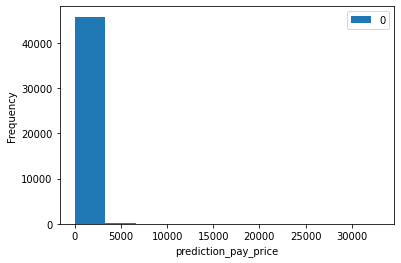

In [ ]:
raw_y[raw_y > 0].plot.hist()
plt.xlabel("prediction_pay_price")
plt.show()

In [ ]:
raw_x.head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105
0,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.166667,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.166667,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.500000,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,0.0


We notice that many of the values for the pay price in the first 45 days is 0 indicating many users don't pay at all (this observation informs our decision later on to split the problem into two parts where we first determine if a user will pay or not).

In [ ]:
raw_x.loc[:,104]

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2288002    0.0
2288003    0.0
2288004    0.0
2288005    0.0
2288006    0.0
Name: 104, Length: 2288007, dtype: float64

In order to find out how many users have paid in the first 45 days and how much have they paid, we will take ***raw_y*** and take only the values that are greater than 0 at index 0. We see we are only left with 45,988 rows, which tells us this is how many people have paid in the first 45 days, and the values in the table can tell us how much each user paid.


In [ ]:
y_positive = raw_y[raw_y.loc[:,0]>0]
y_positive

,0
25,0.99
40,4.96
47,12.97
86,0.99
119,0.99
...,...
2287944,0.99
2287946,932.33
2287960,20.96
2287970,0.99


We can similarly find how many people have paid in the first 7 days and how much they paid by similarly only keeping the rows in which the value in column 104 is greater than 0. This time we can see that we are left with 41,439 such rows which again tells us how many people paid in the first 7 days, and we can see the amount each user paid respresented as the value at index 104.

In [ ]:
x_positive = raw_x[raw_x.loc[:,104]>0]
x_positive

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105
25,30000.0,97200.0,20000.0,0.0,0.0,0.0,160500.0,80392.0,12000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,0.0,75.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.666667,0.99,1.0
40,1111744.0,1137687.0,491331.0,790208.0,77000.0,0.0,1457249.0,708483.0,217455.0,162987.0,370.0,310.0,0.0,295.0,370.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0,1226.0,505.0,573.0,500.0,733.0,17.0,618.0,592.0,6.0,0.0,8.0,10.0,0.0,0.0,9.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,6.0,6.0,6.0,199.333333,2.97,3.0
47,249050.0,173248.0,70841.0,117012.0,55000.0,0.0,206366.0,82205.0,29902.0,88064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,670.0,1380.0,0.0,0.0,419.0,699.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.333333,12.97,3.0
86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.833333,0.99,1.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.166667,0.99,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287944,3279816.0,3366797.0,731921.0,499296.0,226000.0,0.0,4839787.0,2895329.0,861576.0,528802.0,634.0,2312.0,674.0,1531.0,322.0,913.0,634.0,634.0,444.0,444.0,322.0,322.0,3435.0,229.0,1566.0,637.0,786.0,40.0,1736.0,90.0,162.0,0.0,6.0,7.0,8.0,8.0,7.0,7.0,7.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,8.0,7.0,21.0,21.0,15.0,168.666667,0.99,1.0
2287946,94586282.0,87787739.0,74282980.0,71081893.0,33097976.0,31209557.0,81641697.0,80006876.0,8564119.0,7934800.0,24204.0,17796.0,25719.0,17361.0,27110.0,14145.0,6581.0,6142.0,7284.0,6662.0,8126.0,7567.0,80651.0,79956.0,38702.0,38694.0,39129.0,39129.0,75875.0,75709.0,1300.0,302.0,9.0,12.0,16.0,15.0,15.0,13.0,13.0,11.0,...,0.0,0.0,0.0,0.0,8.0,4.0,2.0,7.0,1.0,1.0,2.0,5.0,3.0,1.0,2.0,5.0,2.0,1.0,3.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,51.0,36.0,38.0,161.0,161.0,151.0,548.500000,352.77,23.0
2287960,7136284.0,4755680.0,2971154.0,1284632.0,1427000.0,0.0,9909008.0,3862513.0,1259734.0,578826.0,331.0,1037.0,836.0,964.0,221.0,824.0,331.0,331.0,291.0,291.0,221.0,221.0,4859.0,138.0,3715.0,2042.0,3791.0,844.0,1677.0,37.0,239.0,0.0,8.0,9.0,9.0,8.0,8.0,9.0,8.0,8.0,...,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,7.0,77.0,77.0,74.0,185.666667,0.99,1.0
2287970,2548198.0,2127139.0,655779.0,401296.0,209000.0,0.0,2907185.0,2081544.0,272164.0,203788.0,682.0,2707.0,1074.0,2909.0,500.0,1735.0,2169.0,492.0,2422.0,504.0,1407.0,310.0,2864.0,2731.0,697.0,432.0,995.0,895.0,

We'll take our new tables, ***x_positive*** and ***y_positive*** and take the lengths of both tables to get the total number of users paid, as well as the sum of the values to get the total amount paid by the 7th day and 45th day respectively.

In [ ]:
num_7 = len(x_positive)
num_45 = len(y_positive)
amount_7 = sum(x_positive.loc[:,104])
amount_45 = sum(y_positive.loc[:,0])

In [ ]:
(num_45-num_7)/num_7

0.10977581505345206

In [ ]:
(amount_45-amount_7)/amount_7

2.3537486299888317

Here we are combining the two important features we have been discussing into one dataframe by taking the pay_price in the first 7 days and adding this as a column named ***pay_price*** and the pay_price in the first 45 days as a column named ***prediction_pay_price***.

In [ ]:
s1 = raw_x.loc[:,104]
s2 = raw_y.loc[:,0]
contract = pd.concat([s1, s2],axis=1)
contract = contract.rename(columns={104:"pay_price", 0:"prediction_pay_price"})
contract

,pay_price,prediction_pay_price
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
2288002,0.0,0.0
2288003,0.0,0.0
2288004,0.0,0.0
2288005,0.0,0.0


##1.4 The importance of doing classfication before regression

Below we calculate number of people who didn't paid in 7 days but paid in 45 days and we find that there are 4,549 such users.

In [ ]:
increase = len(contract.loc[(contract["pay_price"]==0) & (contract["prediction_pay_price"]>0)])

In [ ]:
increase

4549

We also see the number of users who do not pay at all in the first 45 days turns out to be 2,242,019 out of 2,288,007 (over 97% of all our data). Thus we have chosen to treat separately the problem of figuring out whether or not a user pays at all (classification), and then from the users that do pay, figuring out how much they pay (regression).

In [ ]:
none = len(contract.loc[contract["prediction_pay_price"] == 0])
none

2242019

In [ ]:
none/len(contract)

0.9799004111438471

##1.5 Data Cleaning
While we have already been consolidating our data to a format close to what we want, we will further clean what we have by doing the following:
1.   selecting the features with high variance
2.   removing rows with NA's



In [ ]:
import sklearn
import sklearn.feature_selection as fs

In [ ]:
selector = fs.VarianceThreshold()
after = selector.fit_transform(raw_x)

In [ ]:
raw_x = raw_x.dropna()

##1.6 Preparing the data for Spark

Further prepping the data, we will be randomly selecting a subset of the data with around 100,000 records to avoid colab crash. Then we'll convert the label data from a float to {0,1} where we assign a 0 if no payment was made in the first 7 days and 1 otherwise. We will create a datafram by concatenating all the features and a column for the label.



In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(raw_x, raw_y, test_size=0.95)

In [ ]:
label = y_train>0
label = label.astype(int)
label = label.rename(columns={0:"label"})

In [ ]:
df = pd.concat([x_train, label], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,label
1313881,10000.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0
1289871,681089.0,381216.0,200000.0,0.0,203000.0,0.0,1501942.0,775279.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663.0,278.0,352.0,97.0,55.0,2.0,95.0,0.0,10.0,0.0,1.0,1.0,2.0,1.0,3.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,7.166667,0.0,0.0,0
1080317,52038.0,9680.0,0.0,0.0,0.0,0.0,46005.0,6645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.166667,0.0,0.0,0
170510,108023.0,56629.0,0.0,0.0,3000.0,0.0,97604.0,32024.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.000000,0.0,0.0,0
1094262,27625.0,4700.0,0.0,0.0,0.0,0.0,32625.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646578,110656.0,25494.0,0.0,0.0,3000.0,0.0,122347.0,16496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,1.0,50.0,0.0,95.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.666667,0.0,0.0,0
169866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0
1400733,10000.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0
1142686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.166667,0.0,0.0,0


We create a spark dataframe from the pandas dataframe

In [ ]:
sdf = spark.createDataFrame(df)

In [ ]:
sdf.show()

+--------+--------+--------+---+--------+---+---------+--------+-------+---+----+----+----+----+---+---+----+---+---+---+---+---+-----+-----+-----+----+----+---+-----+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------------------+---+---+-----+
|       0|       1|       2|  3|       4|  5|        6|       7|      8|  9|  10|  11|  12|  13| 14| 15|  16| 17| 18| 19| 20| 21|   22|   23|   24|  25|  26| 27|   28| 29|  30| 31| 32| 33| 34| 35| 36| 37| 38| 39| 40| 41| 42| 43| 44| 45| 46| 47| 48| 49| 50| 51| 52| 53| 54| 55| 56| 57| 58| 59| 60| 61| 62| 63| 64| 65| 66| 67| 68| 69| 70| 71| 72| 73| 74| 75| 76| 77| 78| 79| 80| 81| 82| 83| 84| 85| 86| 87| 88| 89| 90| 91| 92| 93| 94| 95| 96| 97| 98| 99|100|101|102|               103|104|105|label|
+---

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [ ]:
assembler = VectorAssembler(inputCols=sdf.columns,outputCol="features")

pipe = Pipeline(stages=[assembler])
modified_data_sdf = pipe.fit(sdf).transform(sdf)

Here we divide the dataset into a training set and a test set.

In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed=3)

In [ ]:
train_sdf.printSchema

<bound method DataFrame.printSchema of DataFrame[0: double, 1: double, 2: double, 3: double, 4: double, 5: double, 6: double, 7: double, 8: double, 9: double, 10: double, 11: double, 12: double, 13: double, 14: double, 15: double, 16: double, 17: double, 18: double, 19: double, 20: double, 21: double, 22: double, 23: double, 24: double, 25: double, 26: double, 27: double, 28: double, 29: double, 30: double, 31: double, 32: double, 33: double, 34: double, 35: double, 36: double, 37: double, 38: double, 39: double, 40: double, 41: double, 42: double, 43: double, 44: double, 45: double, 46: double, 47: double, 48: double, 49: double, 50: double, 51: double, 52: double, 53: double, 54: double, 55: double, 56: double, 57: double, 58: double, 59: double, 60: double, 61: double, 62: double, 63: double, 64: double, 65: double, 66: double, 67: double, 68: double, 69: double, 70: double, 71: double, 72: double, 73: double, 74: double, 75: double, 76: double, 77: double, 78: double, 79: double, 8

##1.7 Balancing the Data

For training neural networks and logistic regressions, we want to have balanced data, with similar numbers of positive and negative labels. We will create a more balanced dataset by taking a roughly equal amount of "true" and "false" data meaning we will consider a similar amount of data where the user pays as where the user doesn't pay. We do this by taking a subset of our entire dataset, (which will mostly be 0/non-paying users) as well as a similarly sized subset of only the users that do pay. After balancing the data, we have 2 datasets to use, one for 7 day payment predictions, and one for 45 day payment predictions.

For predicting if one pays by the 45 day mark, we use all information available about the user by the 7 day mark, including if they have paid by 7 days. For the 7 day mark, we exclude the feature noting their payment in the first 7 days, and use this feature as the label instead. 

In the 7 day data, 37% of users pay.

In the 45 day data, 41% of users pay.



In [ ]:
from sklearn.model_selection import train_test_split

#creating a balanced data set for training
true_vals = raw_y.where(raw_y>0).dropna()
true_xs = np.take(raw_x, true_vals.index, axis =0)

#limiting amount of considered data points for ram considerations
usable_data_x, _, usable_data_y, _ = train_test_split(raw_x, raw_y, test_size = .97)

#creating balanced datasets with ~50% true and false labels
log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(usable_data_x, usable_data_y, test_size = .1)
log_x_train_true, log_x_test_true, log_y_train_true, log_y_test_true = train_test_split(true_xs, true_vals, test_size = .1)

## Creating Data set for 45 day payment prediction (including 7 day payment)
balanced_x_train = pd.concat([log_x_train, log_x_train_true], axis = 0)

unbooleaned_y_train = pd.concat([log_y_train, log_y_train_true], axis = 0)
balanced_y_train = unbooleaned_y_train > 0

balanced_x_test = pd.concat([log_x_test, log_x_test_true])

unbooleaned_y_test = pd.concat([log_y_test, log_y_test_true]) 
balanced_y_test = unbooleaned_y_test> 0

## Creating Data set for 7 day payment prediction
seven_day_y_train = balanced_x_train.loc[:,104] > 0
seven_day_y_test = balanced_x_test.loc[:,104] > 0

seven_day_x_train = balanced_x_train.loc[:,:103]
seven_day_x_test = balanced_x_test.loc[:,:103]


#Part 2 Building the Models

## Part 2.1 Predicting if someone is likely to pay for in game purchases or not

We will first try to figure out the best way to predict whether or not users will pay at all. This is a classification problem for which we will try 3 different models.

###2.1.1: Train Classfication Model using Random Forest Classifier



*   We do the following steps several times to test for different reduced dimentionality k


1.   Initialize a PCA model
2.   Fit the model using the training data
3.   Get the PCA feature from the trained model
4.   Train a random forest binary classfication model using the PCA features
5.   Evaluate the performance on the test set 

We will be using PCA to reduce dimensionality of the data set (which contains 106 features) by identifying features that may be correlated with each other and reducing these in a way that will minimize information loss. This will help us run our models more efficiently. We can see when we use our training data to fit our PCA model, we see from the plot shown below that we can reduce from 106 features to just 80 without affecting our results significantly.
Knowing this, we will be using the first 80 features from our PCA to train a random forest binary classification model to see how well we can predict whether or not a user pays at all. We are able to get 85.7% accuracy which tells us we can pretty reliably tell whether a user pays or not. 



In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
train_errs=[]
errs=[]
for i in range(50, 110, 10):
  pca = PCA(k=i, inputCol="features", outputCol="pcaFeatures").fit(train_sdf)
  result = pca.transform(train_sdf)
  result_test = pca.transform(test_sdf)
  rc_model = RandomForestClassifier(featuresCol='pcaFeatures', labelCol='label').fit(result)

  predictions_train = rc_model.transform(result)
  predictions = rc_model.transform(result_test)

  areaUnderROC = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')
  train_err_rc = areaUnderROC.evaluate(predictions_train)
  err_rf = areaUnderROC.evaluate(predictions)
  train_errs.append(train_err_rc)
  errs.append(err_rf)

Text(0.5, 1.0, 'training error vs reduced dimetionality k')

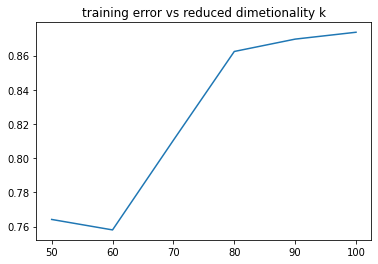

In [ ]:
plt.plot([50,60,70,80,90,100], train_errs)
plt.title("training error vs reduced dimetionality k")

In [ ]:
pca = PCA(k=80, inputCol="features", outputCol="pcaFeatures").fit(train_sdf)
result = pca.transform(train_sdf)
result_test = pca.transform(test_sdf)
rc_model = RandomForestClassifier(featuresCol='pcaFeatures', labelCol='label').fit(result)

predictions_train = rc_model.transform(result)
predictions = rc_model.transform(result_test)

areaUnderROC = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')
train_err_rc = areaUnderROC.evaluate(predictions_train)
err_rf = areaUnderROC.evaluate(predictions)


In [ ]:
train_err_rc

0.86242150240518

In [ ]:
err_rf

0.8573903538710311

### 2.1.2 Logistic Regression for predicting whether one pays by the seven day mark, or the 45 day mark. 

Alternatively, we can try a Logistic Regression model to similarly predict whether or not a user pays within 45 days and 7 days. This time, we recognize that since our data indicates over 97% of users don't pay it is unbalanced, which means our previous classification model may have seen a very high accuracy just by "guessing" 0 every time. This time, with the balanced dataset our Logistic Regression model produces the following results:

A logisitic regressor is built for each prediction:

45 day Logistic Regression: ~80.2% training accuracy, ~80.1% testing accuracy

7 day Logistic Regression: ~88.9% training accuracy, ~88.7% testing accuracy

&nbsp;

We can see from these results that while the accuracies are not significantly better than the random forest model, we can be more confident in saying our model is actually predicting whether or not a user pays as opposed to just guessing that all users do not pay.


In [ ]:
from sklearn.linear_model import LogisticRegression
Logr_45 = LogisticRegression(max_iter = 100)
Logr_45.fit(balanced_x_train, balanced_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Logr_45.score(balanced_x_train, balanced_y_train)

0.8020646537100761

In [ ]:
Logr_45.score(balanced_x_test, balanced_y_test)

0.8015353746837651

In [ ]:
Logr_7 = LogisticRegression(max_iter = 100)
Logr_7.fit(seven_day_x_train, seven_day_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Logr_7.score(seven_day_x_train, seven_day_y_train)

0.8894295545970048

In [ ]:
Logr_7.score(seven_day_x_test, seven_day_y_test)

0.8868533542702608

###2.1.3 Keras Neural Network classifier 


We will now use our own neural network to try and achieve even better results than the previous two attempts. We will again be using the balanced data so we know we're not just guessing 0's. We will train a neural network model with 4 hidden layers and we see after 10 epochs that indeed we achieve an accuracy of ~87.8% which is better than the ~85.7% from our random forest model and the 80.1% from our logistic regression model.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD 
import matplotlib.pyplot as plt

Epoch 1/10
11/11 [==============================] - 0s 8ms/step - loss: 0.7281 - accuracy: 0.4785
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6775 - accuracy: 0.5891
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6300 - accuracy: 0.8003
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5852 - accuracy: 0.8563
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5385 - accuracy: 0.8706
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.5163 - accuracy: 0.8752
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.4818 - accuracy: 0.8801
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.4670 - accuracy: 0.8746
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.4628 - accuracy: 0.8759
Epoch 10/10
11/11 [==============================] - 0s 6ms/step - loss: 0.4394 - accuracy: 0.8824


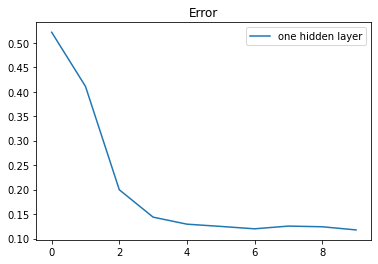

In [ ]:
model1 = Sequential()
model1.add(Dense(units=64, activation='tanh',input_dim = 106))
model1.add(Dense(units=128, activation='tanh',input_dim = 64))
model1.add(Dense(units=32, activation='tanh',input_dim = 128))
model1.add(Dense(units=16, activation='tanh',input_dim = 32))
model1.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
model1.compile(optimizer= sgd,
             loss='binary_crossentropy',
             metrics=['accuracy'])

#Train the model(4 hidden layers)
history1 = model1.fit(balanced_x_train, balanced_y_train, batch_size=10000, epochs = 10)
#Trianing error for 4 hidden layers
hist_plot1 = [1-i for i in history1.history['accuracy'] ]
plt.plot(hist_plot1,label='one hidden layer')
plt.title('Error')
plt.legend()

In [ ]:
predictions = (model1.predict(balanced_x_test)>0.5).astype(int)

In [ ]:
acc = len(predictions[predictions == balanced_y_test])/len(predictions)

In [ ]:
acc

0.8785658204658466

##2.2 Precting *how much* users will pay in this game

Now that we know we can predict whether or not a user will pay at all, we will try to predict how much a user pays after we have identified if they will pay at all. This can be seen as a regression problem which we will also tackle in 3 to see which works best.

###2.2.1: Linear Regression on all users after pre-processing with PCA model

First, we will try using linear regression on all users (paying and non-paying). We again use PCA to reduce dimensionality and observe training accuracy of about 83.8% and testing accuracy of about 83.7%. While we might be tempted to see a high accuracy and think we have a working model, we must remember that this model used data for both paying and non-paying users which means we again have a large fraction of our data representing users that don't pay at all (pay a value of 0).

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
pca_lr = LinearRegression(featuresCol="features", labelCol="label", \
                                  regParam=0.1, elasticNetParam=0).fit(result)
training_r2_pca = r2.evaluate(pca_lr.transform(result))  

In [ ]:
training_r2_pca

0.8387879372307209

In [ ]:
predictions = pca_lr.transform(result_test)
test_r2_pca = r2.evaluate(predictions)

In [ ]:
test_r2_pca

0.8368753907070251

In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105
1313881,10000.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0
1289871,681089.0,381216.0,200000.0,0.0,203000.0,0.0,1501942.0,775279.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663.0,278.0,352.0,97.0,55.0,2.0,95.0,0.0,10.0,0.0,1.0,1.0,2.0,1.0,3.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,7.166667,0.0,0.0
1080317,52038.0,9680.0,0.0,0.0,0.0,0.0,46005.0,6645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.166667,0.0,0.0
170510,108023.0,56629.0,0.0,0.0,3000.0,0.0,97604.0,32024.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.000000,0.0,0.0
1094262,27625.0,4700.0,0.0,0.0,0.0,0.0,32625.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646578,110656.0,25494.0,0.0,0.0,3000.0,0.0,122347.0,16496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,1.0,50.0,0.0,95.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.666667,0.0,0.0
169866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
1400733,10000.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0
1142686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.166667,0.0,0.0


###2.2.2 SkLearn Linear Regression from PCA data, but only considering users who will pay at all


For this Linear Regression, we will only use users who have shown themselves likely to pay for the game. This linear regression model will not be considering users that will have paid 0 (we want to exclude data points for people that will not pay for a game). As before, we will use PCA to reduce dimensionality. With this model, we observe r-squared values of ~0.536 for training and ~0.621 for testing. We can interpret this to mean about 62% of our data fit our regression model.

In [ ]:
only_paid = raw_y[raw_y>0].dropna()
only_paid_x = np.take(raw_x, only_paid.index, axis =0)
print(len(only_paid))
from sklearn.model_selection import train_test_split

only_paid_x_train, only_paid_x_test, only_paid_y_train, only_paid_y_test = train_test_split(only_paid_x, only_paid, test_size = .1)

45988


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
X_test = StandardScaler().fit_transform(only_paid_x_test)
X_train = StandardScaler().fit_transform(only_paid_x_train)
pca=PCA(n_components=80).fit(only_paid_x_train)
x_train = pca.transform(only_paid_x_train)
x_test = pca.transform(only_paid_x_test)

In [ ]:
from sklearn.linear_model import LinearRegression

lr_pca = LinearRegression()
lr_pca.fit(x_train, only_paid_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Training R^2:

In [ ]:
lr_pca.score(x_train,only_paid_y_train)

0.5357017916390141

Testing R^2

In [ ]:
lr_pca.score(x_test, only_paid_y_test)

0.6210150835517823

### 2.2.3 Linear Regression from raw data and only considering those who paid

While we have assumed throughout this project that using PCA does not significantly change our results, we will put this to the test by trying the same linear regression from part 2.2.1 except without using PCA to reduce dimensionality, meaning we will be considering all 106 original features in our regression. We see that in doing so, we observe r-squared values of ~0.551 for training and ~0.646.

In [ ]:
lr = LinearRegression()
lr.fit(only_paid_x_train, only_paid_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Training R^2

In [ ]:
lr.score(only_paid_x_train,only_paid_y_train)

0.5514007756550197

Testing R^2

In [ ]:
lr.score(only_paid_x_test,only_paid_y_test)

0.6456638436457193

# Part 3  Predicting the success of your game!

Assuming that your game is as exciting and promotional for in-game purchases as Brutal Force, we can predict how much users will spend on your game!

To do so, we will use our neural network model on your user data to find those that are likely to pay at all, and then use our linear regression model to predict how much each of those users will pay in total!

In [ ]:
def game_profits(userbase):
  ## First we run our neural network to find users that will pay at all
  predicted_payment_label = (model1.predict(userbase)>0.5).astype(int)
  indeces = [x  for x in range(len(predicted_payment_label)) if predicted_payment_label[x] == 1]
  to_use = userbase.iloc[indeces]
  payments = lr.predict(to_use)
  print(f"Given your {userbase.shape[0]} users, we expect {len(to_use)} users to invest in in-game purchases. In total, we expect you to earn ${payments.sum()} in 45 days")
  return payments.sum()

money_made = game_profits(balanced_x_train)

Given your 103165 users, we expect 41231 users to invest in in-game purchases. In total, we expect you to earn $3648994.881293071 in 45 days


# Part 4 Project Summary

In looking at the game Brutal Force's user data, we have used 6 "different" models to figure out the best way to first classify whether or not users will pay, and then use a regression for the users identified as "paying users" to predict how much these users will pay. In preparing our data, we realized that as is the case with many games with both paid and unpaid features, a large majority of users did not pay at all for the game which led to an overwhelming amount of data that had value 0. In response to this, we balanced the data and followed our two step approach.
We found that by comparing accuracies accross our models, the Neural Network performed the best among the models used to classify if a user paid or not with an accuracy of around 87%, and for the regression we found best results with our linear regression without PCA. Then using these models, we created a predictor that can be used for other games with similar user data that can predict whether users will pay for the game or not as well as how much users will spend on your game. We can see this being useful to someone trying to release a game with paid and unpaid options, to help decide how much certain features should cost, how much the game can be expected to make, and whether or not the project is worth it overall!